# **Feed Forward Neural Network Trained on Fashion MNIST Dataset**

### **Initial Setup** ###

In [ ]:
!pip install torch
!pip install kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

### **External Libraries** ###

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import models
from torch.utils.data import DataLoader, TensorDataset, Dataset
import pandas as pd
from torchvision import transforms
import numpy as np
import os
import cv2
from skimage.feature import hog
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from PIL import Image
import requests
from io import BytesIO

### **Creating the network architecture.** ###

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        # Fully connected layers
        self.fc1 = nn.Linear(784, 620)  # Input layer
        self.fc2 = nn.Linear(620, 456)  # Hidden layer 1
        self.fc3 = nn.Linear(456, 292)  # Hidden layer 2
        self.fc4 = nn.Linear(292, 128)  # Hidden layer 3
        self.fc_output = nn.Linear(128, 10)  # Output layer

    def forward(self, x):
        # Flatten the input (Fashion MNIST images are 28x28 pixels)
        x = x.view(-1, 784)

        # Pass through the layers with ReLU activations
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = self.fc_output(x)  # No activation for the final output layer
        return x

# Instantiate the network and print its architecture
my_nn = Net()
print(my_nn)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(my_nn.parameters(), lr=0.001)

Net(
  (fc1): Linear(in_features=784, out_features=620, bias=True)
  (fc2): Linear(in_features=620, out_features=456, bias=True)
  (fc3): Linear(in_features=456, out_features=292, bias=True)
  (fc4): Linear(in_features=292, out_features=128, bias=True)
  (fc_output): Linear(in_features=128, out_features=10, bias=True)
)


### **Load the Fashion MNIST dataset.** ###

In [ ]:
!kaggle datasets download -d zalando-research/fashionmnist
!unzip fashionmnist.zip -d fashionmnist/

Dataset URL: https://www.kaggle.com/datasets/zalando-research/fashionmnist
License(s): other
 97% 67.0M/68.8M [00:03<00:00, 23.2MB/s]
100% 68.8M/68.8M [00:04<00:00, 17.9MB/s]
Archive:  fashionmnist.zip
  inflating: fashionmnist/fashion-mnist_test.csv  
  inflating: fashionmnist/fashion-mnist_train.csv  
  inflating: fashionmnist/t10k-images-idx3-ubyte  
  inflating: fashionmnist/t10k-labels-idx1-ubyte  
  inflating: fashionmnist/train-images-idx3-ubyte  
  inflating: fashionmnist/train-labels-idx1-ubyte  


### **Data Preprocessing.** ###

In [ ]:
# Load CSV files
train_data = pd.read_csv('fashionmnist/fashion-mnist_train.csv')
val_data = pd.read_csv('fashionmnist/fashion-mnist_test.csv')

# Separate features and labels for training and test sets
X_train = train_data.iloc[:, 1:].values / 255.0  # Normalize pixel values to [0, 1]
y_train = train_data.iloc[:, 0].values           # Labels

X_val = val_data.iloc[:, 1:].values / 255.0    # Normalize pixel values to [0, 1]
y_val = val_data.iloc[:, 0].values             # Labels

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)

# Create TensorDataset and DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

### **Training the architecture for 100 Epochs (Test Data is used as Validation Data).** ###

In [ ]:
# Initialize lists to store losses and accuracy values for plotting
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    # Training phase
    my_nn.train()  # Set the model to training mode
    running_train_loss = 0.0
    correct_train = 0
    total_train = 0
    for images, labels in train_loader:
        optimizer.zero_grad()              # Clear gradients
        outputs = my_nn(images)            # Forward pass
        loss = criterion(outputs, labels)  # Compute the loss
        loss.backward()                    # Backward pass
        optimizer.step()                   # Update weights

        running_train_loss += loss.item()

        # Calculate training accuracy
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    # Average training loss and accuracy for the epoch
    avg_train_loss = running_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    train_accuracy = correct_train / total_train
    train_accuracies.append(train_accuracy)

    # Validation phase
    my_nn.eval()  # Set the model to evaluation mode
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():  # Disable gradient tracking for validation
        for images, labels in val_loader:
            outputs = my_nn(images)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()

            # Calculate validation accuracy
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    # Average validation loss and accuracy for the epoch
    avg_val_loss = running_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    val_accuracy = correct_val / total_val
    val_accuracies.append(val_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Train Acc: {train_accuracy*100:.4f}%, Val Acc: {val_accuracy*100:.4f}%")

Epoch [1/100], Train Loss: 0.3326, Val Loss: 0.3206, Train Acc: 87.9483%, Val Acc: 88.1900%
Epoch [2/100], Train Loss: 0.3082, Val Loss: 0.3283, Train Acc: 88.6933%, Val Acc: 87.4900%
Epoch [3/100], Train Loss: 0.2904, Val Loss: 0.3444, Train Acc: 89.2633%, Val Acc: 88.0400%
Epoch [4/100], Train Loss: 0.2749, Val Loss: 0.3198, Train Acc: 89.8500%, Val Acc: 88.5900%
Epoch [5/100], Train Loss: 0.2633, Val Loss: 0.3373, Train Acc: 90.2667%, Val Acc: 88.0300%
Epoch [6/100], Train Loss: 0.2496, Val Loss: 0.3127, Train Acc: 90.6617%, Val Acc: 89.6500%
Epoch [7/100], Train Loss: 0.2412, Val Loss: 0.3024, Train Acc: 90.8900%, Val Acc: 89.3600%
Epoch [8/100], Train Loss: 0.2316, Val Loss: 0.3040, Train Acc: 91.3333%, Val Acc: 89.2600%
Epoch [9/100], Train Loss: 0.2202, Val Loss: 0.3058, Train Acc: 91.5950%, Val Acc: 89.3000%
Epoch [10/100], Train Loss: 0.2148, Val Loss: 0.2998, Train Acc: 91.8817%, Val Acc: 89.8500%
Epoch [11/100], Train Loss: 0.2039, Val Loss: 0.3207, Train Acc: 92.3450%, Val 

### **Training & Validation Accuracy.** ###

In [ ]:
# Final training and validation accuracy
print(f"Final Training Accuracy: {train_accuracies[-1]*100:.4f}%")
print(f"Final Validation Accuracy: {val_accuracies[-1]*100:.4f}%")

Final Training Accuracy: 98.7833%
Final Validation Accuracy: 90.4600%


Plot both the training loss as well as the validation loss on the same plot.

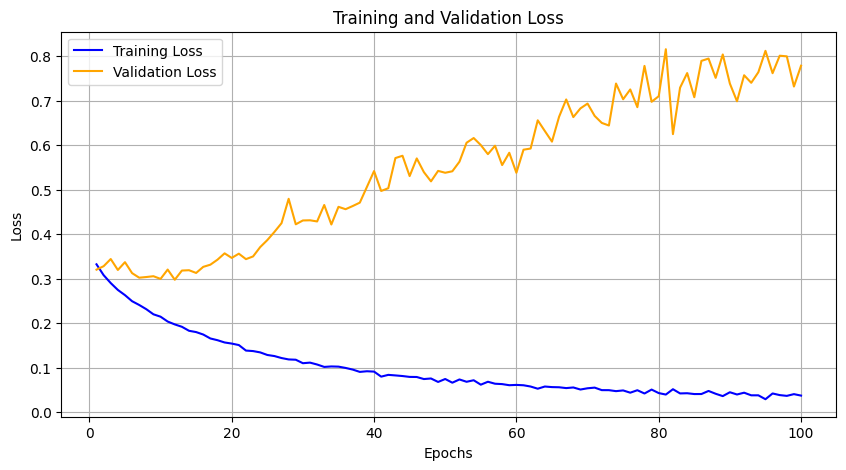

In [ ]:
# Plotting the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss', color='blue')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss', color='orange')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

Plot both the training accuracy as well as the validation accuracy on the same plot.

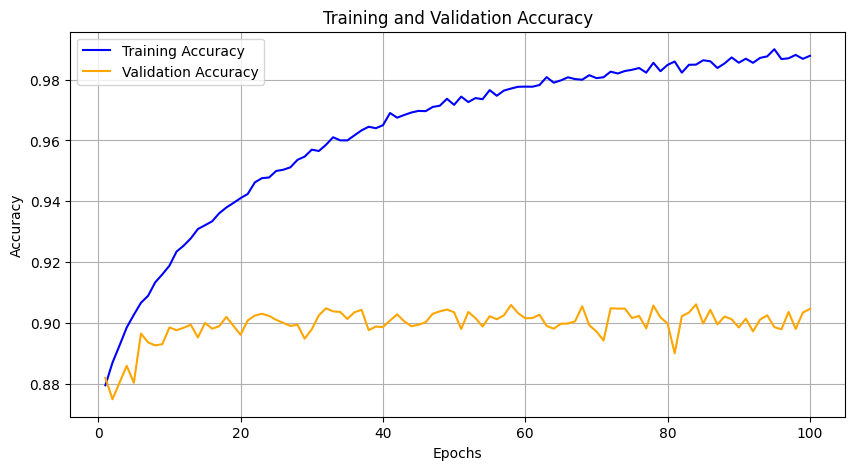

In [ ]:
# Plotting the training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy', color='blue')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy', color='orange')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()